# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                             
Sample_063  Q9P121-4                                                                      19.196
Sample_029  O95967                                                                        17.720
Sample_114  Q6MZW2                                                                        17.345
Sample_203  A2A3C1;A2A3C2;A2A3C3;A2A3C4;A2A3C6;E9PND1;O60241;O60241-2;O60241-3;O60241-4   18.202
Sample_101  Q96FE7-4                                                                      19.387
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups               
Sample_133  I3L397;I3L504;P63241;P63241-2   13.321
Sample_019  P22676                          13.046
Sample_020  P22303                          14.974
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.802
            A0A075B6Q5                 12.060
            A0A075B6R2                 13.757
            A0A075B6S5                 12.829
            A0A087WSY4                 13.755
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.913
            Q9UI40;Q9UI40-2            12.941
            Q9UIW2                     13.120
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.141
            Q9UP79                     13.073
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.090,15.050,16.842,19.863,15.468,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.434,19.067,...,15.528,15.576,14.005,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.462,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.404,17.705,17.039,16.834,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.920,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.594,15.345,17.084,18.708,14.249,19.433,12.151,11.059
Sample_207,15.739,16.877,15.469,16.898,15.744,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.802,...,16.012,15.178,11.898,15.050,16.842,19.863,13.138,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.985,19.067,16.188,...,15.528,15.576,11.430,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.894,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.573,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.445,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.912,15.345,17.084,18.708,14.249,19.433,12.696,12.159
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 364.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.91it/s]

100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.06it/s]

100%|██████████| 4/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.06it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.50it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.06it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.95it/s]

100%|██████████| 6/6 [00:01<00:00,  2.87it/s]

100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.79it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.14it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.65it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.48it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.59it/s]

100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.18it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.97it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.86it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.70it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.49it/s]

100%|██████████| 8/8 [00:02<00:00,  3.37it/s]

100%|██████████| 8/8 [00:02<00:00,  3.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.98it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.43it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.12it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.30it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.91it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.67it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.44it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.90it/s]

 30%|███       | 3/10 [00:00<00:01,  4.27it/s]

 40%|████      | 4/10 [00:00<00:01,  3.78it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.06it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.99it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.79it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.69it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.76it/s]

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.15it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.77it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.30it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.14it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.31it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.46it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.66it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.80it/s]

100%|██████████| 11/11 [00:04<00:00,  2.90it/s]

100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.55it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.05it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.76it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.69it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.49it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.74it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.45it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.26it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.25it/s]

100%|██████████| 12/12 [00:04<00:00,  2.38it/s]

100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.17it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.07it/s]

 31%|███       | 4/13 [00:01<00:02,  3.64it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.39it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.25it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.16it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.11it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.06it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.09it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.16it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.08it/s]

100%|██████████| 13/13 [00:03<00:00,  3.09it/s]

100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.39it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.55it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.95it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.98it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.60it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.40it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.55it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.73it/s]

100%|██████████| 14/14 [00:04<00:00,  2.73it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.90it/s]

 20%|██        | 3/15 [00:00<00:02,  4.69it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.82it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.15it/s]

 40%|████      | 6/15 [00:01<00:03,  2.99it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.08it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.05it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.07it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.22it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.32it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.35it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.37it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.38it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.049 0.010          0.617 0.426       0.087   
2             0.004 0.000      0.046 0.004          0.683 0.122       0.470   
3             0.004 0.003      0.049 0.007          0.687 0.114       0.523   
4             0.004 0.000      0.047 0.002          0.806 0.084       0.805   
5             0.004 0.000      0.046 0.003          0.803 0.080       0.811   
6             0.004 0.000      0.055 0.015          0.795 0.078       0.815   
7             0.005 0.003      0.055 0.014          0.800 0.086       0.794   
8             0.004 0.000      0.047 0.003          0.827 0.078       0.826   
9             0.004 0.000      0.045 0.004          0.825 0.077       0.823   
10            0.004 0.001      0.041 0.005          0.821 0.082       0.823   
11            0.005 0.003      0.053 0.015          0.838 0.083       0.831   
12            0.004 0.000      0.047 0.003          0.831 0.083       0.832   
13            0.006 0.005      0.063 0.021          0.829 0.082       0.826   
14            0.005 0.002      0.050 0.013          0.826 0.086       0.814   
15            0.010 0.007      0.094 0.034          0.823 0.088       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.147 0.128                  0.536 0.039        0.844   
2          0.121   0.547 0.103                  0.653 0.063        0.714   
3          0.131   0.584 0.103                  0.672 0.067        0.703   
4          0.100   0.801 0.071                  0.830 0.060        0.900   
5          0.108   0.803 0.073                  0.832 0.061        0.898   
6          0.113   0.800 0.073                  0.829 0.061        0.896   
7          0.107   0.792 0.073                  0.822 0.060        0.904   
8          0.097   0.823 0.071                  0.849 0.061        0.917   
9          0.096   0.821 0.069                  0.847 0.059        0.916   
10         0.096   0.819 0.071                  0.845 0.062        0.915   
11         0.095   0.831 0.070                  0.856 0.060        0.920   
12         0.090   0.828 0.068                  0.853 0.058        0.920   
13         0.091   0.824 0.063                  0.849 0.054        0.917   
14         0.099   0.815 0.068                  0.842 0.057        0.916   
15         0.098   0.813 0.068                  0.840 0.057        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.816 0.086        210.000 0.000  
2          0.071                  0.656 0.075        210.000 0.000  
3          0.074                  0.651 0.084        210.000 0.000  
4          0.049                  0.876 0.059        210.000 0.000  
5          0.048                  0.873 0.058        210.000 0.000  
6          0.048                  0.870 0.058        210.000 0.000  
7          0.045                  0.887 0.052        210.000 0.000  
8          0.046                  0.911 0.045        210.000 0.000  
9          0.047                  0.910 0.045        210.000 0.000  
10         0.046                  0.908 0.045        210.000 0.000  
11         0.048                  0.911 0.048        210.000 0.000  
12         0.047                  0.909 0.047        210.000 0.000  
13         0.047                  0.908 0.047        210.000 0.000  
14         0.049                  0.908 0.047        210.000 0.000  
15         0.049                  0.906 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 428.60it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.27it/s]

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.16it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.00it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.81it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.93it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.27it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.02it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.66it/s]

100%|██████████| 7/7 [00:02<00:00,  2.18it/s]

100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.34it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.47it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.32it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.35it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.34it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

100%|██████████| 8/8 [00:03<00:00,  1.93it/s]

100%|██████████| 8/8 [00:03<00:00,  2.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.53it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.84it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.20it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.23it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.81it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.68it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.73it/s]

100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

100%|██████████| 9/9 [00:04<00:00,  2.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.45it/s]

 30%|███       | 3/10 [00:00<00:01,  3.95it/s]

 40%|████      | 4/10 [00:01<00:01,  3.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.05it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.02it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.87it/s]

100%|██████████| 10/10 [00:04<00:00,  1.89it/s]

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.32it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.02it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.81it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.27it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.07it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.97it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.03it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.20it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.36it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.73it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.89it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.35it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.82it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.66it/s]

 58%|█████▊    | 7/12 [00:03<00:03,  1.65it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.78it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.97it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.06it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.05it/s]

100%|██████████| 12/12 [00:05<00:00,  2.12it/s]

100%|██████████| 12/12 [00:05<00:00,  2.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.59it/s]

 31%|███       | 4/13 [00:01<00:03,  2.58it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.19it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.11it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.28it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.28it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.23it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.06it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.03it/s]

100%|██████████| 13/13 [00:05<00:00,  2.02it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.95it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.40it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.44it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.89it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.72it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.61it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.69it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.80it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.89it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.95it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.93it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.00it/s]

100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

100%|██████████| 14/14 [00:06<00:00,  2.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.80it/s]

 20%|██        | 3/15 [00:01<00:04,  2.74it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.41it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.03it/s]

 40%|████      | 6/15 [00:02<00:04,  1.84it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.99it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.16it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.29it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.41it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.53it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.54it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.57it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.63it/s]

100%|██████████| 15/15 [00:06<00:00,  2.67it/s]

100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.076 0.035          0.000 0.000       0.000   
2             0.006 0.005      0.056 0.019          0.707 0.159       0.445   
3             0.007 0.008      0.072 0.032          0.689 0.118       0.549   
4             0.007 0.005      0.078 0.035          0.749 0.101       0.573   
5             0.007 0.006      0.071 0.024          0.693 0.106       0.608   
6             0.005 0.004      0.058 0.021          0.705 0.102       0.620   
7             0.005 0.004      0.064 0.027          0.710 0.099       0.621   
8             0.006 0.005      0.067 0.030          0.784 0.087       0.788   
9             0.005 0.004      0.062 0.024          0.784 0.088       0.784   
10            0.005 0.002      0.060 0.026          0.822 0.094       0.771   
11            0.005 0.003      0.073 0.031          0.838 0.097       0.778   
12            0.005 0.003      0.063 0.024          0.839 0.096       0.789   
13            0.006 0.004      0.063 0.025          0.844 0.093       0.783   
14            0.004 0.002      0.048 0.015          0.833 0.087       0.779   
15            0.006 0.004      0.081 0.031          0.844 0.082       0.780   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.855   
2          0.113   0.532 0.096                  0.647 0.059        0.710   
3          0.118   0.604 0.098                  0.681 0.071        0.726   
4          0.121   0.642 0.095                  0.715 0.063        0.763   
5          0.109   0.641 0.084                  0.702 0.064        0.776   
6          0.121   0.653 0.094                  0.714 0.071        0.783   
7          0.118   0.656 0.091                  0.716 0.068        0.779   
8          0.113   0.781 0.081                  0.813 0.068        0.896   
9          0.115   0.779 0.082                  0.812 0.069        0.895   
10         0.118   0.789 0.081                  0.822 0.066        0.918   
11         0.115   0.801 0.083                  0.832 0.068        0.921   
12         0.116   0.808 0.084                  0.837 0.069        0.921   
13         0.112   0.807 0.079                  0.837 0.064        0.920   
14         0.109   0.800 0.077                  0.831 0.062        0.921   
15         0.110   0.806 0.077                  0.836 0.062        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.089        210.000 0.000  
2          0.088                  0.671 0.115        210.000 0.000  
3          0.081                  0.671 0.099        210.000 0.000  
4          0.069                  0.750 0.083        210.000 0.000  
5          0.068                  0.743 0.085        210.000 0.000  
6          0.074                  0.746 0.091        210.000 0.000  
7          0.074                  0.746 0.091        210.000 0.000  
8          0.051                  0.873 0.058        210.000 0.000  
9          0.052                  0.871 0.058        210.000 0.000  
10         0.044                  0.887 0.059        210.000 0.000  
11         0.045                  0.893 0.057        210.000 0.000  
12         0.044                  0.893 0.057        210.000 0.000  
13         0.045                  0.894 0.058        210.000 0.000  
14         0.044                  0.897 0.054        210.000 0.000  
15         0.043                  0.898 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1008.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 14.87it/s]

100%|██████████| 2/2 [00:00<00:00, 14.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 12.78it/s]

100%|██████████| 3/3 [00:00<00:00, 12.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.02it/s]

100%|██████████| 4/4 [00:00<00:00, 15.80it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 13.57it/s]

 80%|████████  | 4/5 [00:00<00:00, 10.77it/s]

100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.07it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 10.87it/s]

100%|██████████| 6/6 [00:00<00:00, 10.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 14.86it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.43it/s]

100%|██████████| 7/7 [00:00<00:00, 10.50it/s]

100%|██████████| 7/7 [00:00<00:00, 10.85it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 13.85it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 10.95it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  9.58it/s]

100%|██████████| 8/8 [00:00<00:00, 10.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.98it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 10.86it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.05it/s]

100%|██████████| 9/9 [00:00<00:00,  9.74it/s]

100%|██████████| 9/9 [00:00<00:00, 10.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.41it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.99it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.81it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.59it/s]

100%|██████████| 10/10 [00:00<00:00, 11.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.53it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.35it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.04it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.51it/s]

100%|██████████| 11/11 [00:00<00:00, 11.81it/s]

100%|██████████| 11/11 [00:00<00:00, 12.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 14.10it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.05it/s]

 50%|█████     | 6/12 [00:00<00:00,  8.44it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.49it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.19it/s]

100%|██████████| 12/12 [00:01<00:00,  9.90it/s]

100%|██████████| 12/12 [00:01<00:00,  9.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.32it/s]

 31%|███       | 4/13 [00:00<00:00, 10.97it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.04it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.77it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  9.37it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.84it/s]

100%|██████████| 13/13 [00:01<00:00,  9.36it/s]

100%|██████████| 13/13 [00:01<00:00,  9.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.08it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.09it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.09it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.28it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.18it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.83it/s]

100%|██████████| 14/14 [00:01<00:00,  9.48it/s]

100%|██████████| 14/14 [00:01<00:00, 10.25it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.51it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.92it/s]

 40%|████      | 6/15 [00:00<00:00, 10.89it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.71it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.24it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.22it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.17it/s]

100%|██████████| 15/15 [00:01<00:00, 11.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.064 0.018          0.000 0.000       0.000   
2             0.005 0.004      0.064 0.022          0.644 0.084       0.511   
3             0.005 0.004      0.069 0.028          0.642 0.088       0.527   
4             0.006 0.006      0.079 0.037          0.634 0.100       0.513   
5             0.005 0.003      0.054 0.016          0.623 0.093       0.508   
6             0.005 0.003      0.066 0.024          0.657 0.099       0.529   
7             0.005 0.005      0.067 0.031          0.647 0.106       0.530   
8             0.004 0.002      0.055 0.016          0.705 0.081       0.596   
9             0.006 0.005      0.077 0.027          0.715 0.096       0.624   
10            0.004 0.001      0.050 0.018          0.745 0.103       0.655   
11            0.007 0.007      0.085 0.033          0.735 0.093       0.640   
12            0.004 0.002      0.052 0.013          0.726 0.089       0.648   
13            0.007 0.006      0.076 0.031          0.717 0.090       0.646   
14            0.005 0.004      0.056 0.022          0.724 0.093       0.646   
15            0.005 0.004      0.058 0.020          0.721 0.092       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.733   
2          0.086   0.564 0.073                  0.650 0.054        0.736   
3          0.082   0.575 0.070                  0.654 0.055        0.737   
4          0.088   0.563 0.081                  0.647 0.064        0.749   
5          0.083   0.557 0.077                  0.641 0.061        0.742   
6          0.103   0.581 0.090                  0.663 0.065        0.740   
7          0.102   0.577 0.090                  0.657 0.068        0.731   
8          0.105   0.641 0.080                  0.706 0.057        0.780   
9          0.110   0.659 0.082                  0.718 0.062        0.792   
10         0.104   0.690 0.076                  0.741 0.061        0.795   
11         0.114   0.678 0.086                  0.734 0.064        0.811   
12         0.114   0.678 0.083                  0.733 0.062        0.811   
13         0.117   0.673 0.087                  0.728 0.065        0.808   
14         0.119   0.676 0.089                  0.731 0.066        0.804   
15         0.117   0.673 0.088                  0.729 0.065        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.684 0.088        210.000 0.000  
2          0.060                  0.695 0.077        210.000 0.000  
3          0.062                  0.691 0.080        210.000 0.000  
4          0.061                  0.707 0.071        210.000 0.000  
5          0.064                  0.699 0.075        210.000 0.000  
6          0.068                  0.704 0.078        210.000 0.000  
7          0.071                  0.698 0.080        210.000 0.000  
8          0.062                  0.731 0.082        210.000 0.000  
9          0.067                  0.750 0.085        210.000 0.000  
10         0.063                  0.759 0.078        210.000 0.000  
11         0.066                  0.766 0.081        210.000 0.000  
12         0.065                  0.769 0.079        210.000 0.000  
13         0.067                  0.770 0.080        210.000 0.000  
14         0.067                  0.765 0.081        210.000 0.000  
15         0.066                  0.760 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,4,13
score_time,15,15,11
test_precision,11,15,10
test_recall,12,12,10
test_f1,11,12,10
test_balanced_accuracy,11,12,10
test_roc_auc,11,15,12
test_average_precision,11,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.66it/s]

 20%|██        | 3/15 [00:00<00:03,  3.45it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.38it/s]

 40%|████      | 6/15 [00:02<00:04,  2.10it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.96it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.94it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.09it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.14it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.31it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.07it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.09it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.21it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.62it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.38it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.46it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.43it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.67it/s]

100%|██████████| 12/12 [00:00<00:00, 12.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.00it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.70it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.97it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.78it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.55it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.87it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.51it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.39it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:03<00:00,  2.50it/s]

100%|██████████| 11/11 [00:03<00:00,  2.89it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


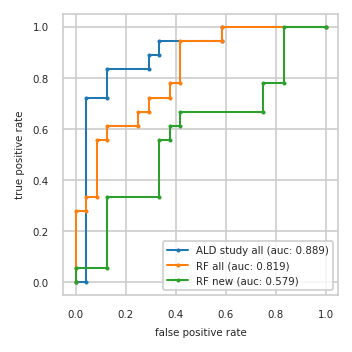

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.722  0.000 0.278  0.125 0.056
3          0.125 0.722  0.042 0.278  0.125 0.333
4          0.125 0.833  0.042 0.333  0.333 0.333
5          0.292 0.833  0.083 0.333  0.333 0.556
6          0.292 0.889  0.083 0.556  0.375 0.556
7          0.333 0.889  0.125 0.556  0.375 0.611
8          0.333 0.944  0.125 0.611  0.417 0.611
9          0.583 0.944  0.250 0.611  0.417 0.667
10         0.583 1.000  0.250 0.667  0.750 0.667
11         1.000 1.000  0.292 0.667  0.750 0.778
12           NaN   NaN  0.292 0.722  0.833 0.778
13           NaN   NaN  0.375 0.722  0.833 1.000
14           NaN   NaN  0.375 0.778  1.000 1.000
15           NaN   NaN  0.417 0.778    NaN   NaN
16           NaN   NaN  0.417 0.944    NaN   NaN
17           NaN   NaN  0.583 0.944    NaN   NaN
18           NaN   NaN  0.583 1.000    NaN   NaN
19           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q8NFY4;Q8NFY4-6,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,P09486,Q96GD0,A6H8L4;E7EUI5;P78536;P78536-2
3,K7ERG9;P00746,Q9HBW1,Q96GD0
4,P14174,P61981,P31321
5,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,J3KSJ8;Q9UD71;Q9UD71-2
6,P61981,P04075,P51688
7,Q6EMK4,P14174,P31150
8,Q9Y2T3;Q9Y2T3-3,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


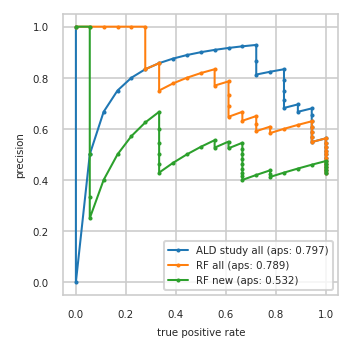

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.412 0.778
9          0.545 1.000     0.545 1.000     0.424 0.778
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.548 0.944     0.548 0.944     0.419 0.722
12         0.567 0.944     0.567 0.944     0.400 0.667
13         0.586 0.944     0.586 0.944     0.414 0.667
14         0.607 0.944     0.607 0.944     0.429 0.667
15         0.630 0.944     0.630 0.944     0.444 0.667
16         0.654 0.944     0.615 0.889     0.462 0.667
17         0.680 0.944     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.789 0.833     0.632 0.667     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.647 0.611     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.867 0.722     0.733 0.611     0.467 0.389
28         0.929 0.722     0.786 0.611     0.429 0.333
29         0.923 0.667     0.769 0.556     0.462 0.333
30         0.917 0.611     0.833 0.556     0.500 0.333
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.600 0.333
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


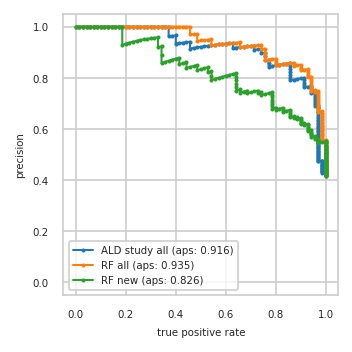

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


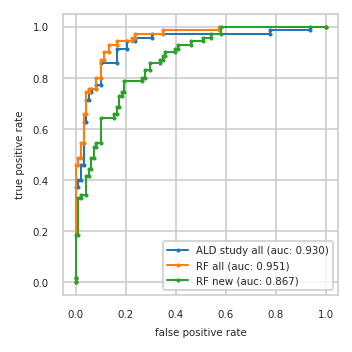

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}